# **EM (Expectation-Minimization) CLUSTERING ANALYSIS**

In [4]:
# Import Libraries
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

## Question 1
Functions and Comments

In [5]:
# Define the main EM clustering function
def exp_max(Iter, K, pdf, train, Xmat, W_Init, P_Init):
    """
    Implements the Expectation-Maximization (EM) algorithm for clustering.

    Args:
        Iter (int): The number of iterations for which the algorithm should run.
        K (int): The number of clusters.
        pdf (function): A probability density function (e.g., normal_pdf) that takes parameters
                        (e.g., mean) and data (Xmat) to return probabilities.
        train (function): A learning function (e.g., normal_train) that fits the optimal parameters
                          (e.g., mean) based on cluster probabilities and data.
        Xmat (numpy.ndarray): An array storing the training data. Dimensions: (n_samples, n_features).
        W_Init (numpy.ndarray): The initial weights for each cluster. Dimensions: (1, K).
        P_Init (numpy.ndarray): The initial choice of parameters for each cluster (e.g., initial means).
                                Dimensions: (n_features, K).

    Returns:
        tuple: A tuple containing:
            - W (numpy.ndarray): The final weights for each cluster. Dimensions: (1, K).
            - P (numpy.ndarray): The final parameters for each cluster (e.g., final means).
                                 Dimensions: (n_features, K).
            - p (numpy.ndarray): The final probabilities associated with every cluster and data point.
                                 Dimensions: (K, n_samples).
    """
    n, D = Xmat.shape  # n = number of samples, D = number of features
    p = np.zeros((K, n))  # Initialize probabilities: K clusters x n samples
    W, P = W_Init, P_Init  # Initialize weights and parameters

    for i in range(0, Iter):
        # E-Step (Expectation Step): Calculate the probability of each data point belonging to each cluster
        for k in range(0, K):
            # p[k,:] calculates the likelihood of each data point Xmat under the current parameters P[:,k]
            # and multiplies by the current weight W[0,k] for cluster k.
            # pdf(P[:,k], Xmat) returns a 1D array of probabilities for each sample.
            p[k,:] = W[0,k] * pdf(P[:,k], Xmat)

        # Normalize probabilities so that for each data point, the sum of probabilities across all clusters is 1.
        # p becomes the responsibility matrix (gamma in EM literature).
        p = (p / np.sum(p, axis=0)) # Sum along axis 0 (columns) to normalize for each data point

        # M-Step (Maximization Step): Update weights and parameters based on the calculated responsibilities
        # Update weights (W): The new weight for each cluster is the average responsibility assigned to it.
        W = np.mean(p, axis=1).reshape(1, K) # Mean along axis 1 (rows) to get average responsibility for each cluster

        # Update parameters (P): For each cluster, train a new set of parameters using the weighted data points.
        # The 'train' function takes the responsibilities for a cluster (p[k,:]) and the data (Xmat).
        for k in range(0, K):
            P[:,k] = train(p[k,:], Xmat)
    return W, P, p

# Define the train function for the Gaussian distribution
def normal_train(p, Xmat):
    """
    Trains the mean parameter for a Gaussian distribution.

    Args:
        p (numpy.ndarray): The responsibilities (probabilities) of data points belonging to a specific cluster.
                           Dimensions: (n_samples,).
        Xmat (numpy.ndarray): The training data. Dimensions: (n_samples, n_features).

    Returns:
        numpy.ndarray: The calculated mean vector for the cluster. Dimensions: (n_features,).
    """
    # Calculate the weighted mean of the data points based on their responsibilities.
    # (Xmat.T @ p.T) performs a weighted sum of data points for each feature.
    # sum(p) is the sum of responsibilities for the cluster.
    m = (Xmat.T @ p.T) / np.sum(p)
    return m

# Define the PDF function for the Gaussian distribution
def normal_pdf(m, Xmat, var=1):
    """
    Calculates the probability density function (PDF) for a multivariate normal distribution.
    Assumes a fixed, symmetric variance.

    Args:
        m (numpy.ndarray): The mean vector of the Gaussian distribution. Dimensions: (n_features,).
        Xmat (numpy.ndarray): The data points for which to calculate the PDF. Dimensions: (n_samples, n_features).
        var (float): The fixed variance for the symmetric Gaussian. Defaults to 1.

    Returns:
        numpy.ndarray: An array of PDF values for each data point. Dimensions: (n_samples,).
    """
    C = np.eye(Xmat.shape[1]) * var # Create a diagonal covariance matrix with 'var' on the diagonal
    mvn = multivariate_normal(mean=m.T, cov=C)
    return mvn.pdf(Xmat)

# Define the K-Means clustering function
def kmeans(eps, K, Xmat, c_init):
    """
    Implements the K-Means clustering algorithm.

    Args:
        eps (float): The convergence threshold. The algorithm stops when the change in centroids
                     is less than this value.
        K (int): The number of clusters.
        Xmat (numpy.ndarray): The data points to be clustered. Dimensions: (n_samples, n_features).
        c_init (numpy.ndarray): The initial centroids for each cluster. Dimensions: (n_features, K).

    Returns:
        tuple: A tuple containing:
            - c (numpy.ndarray): The final centroids for each cluster. Dimensions: (n_features, K).
            - label (numpy.ndarray): An array indicating the cluster assignment for each data point.
                                   Dimensions: (n_samples,).
    """
    n, D = Xmat.shape  # n = number of samples, D = number of features
    c = c_init.copy()  # Initialize centroids
    c_old = np.zeros(c.shape)  # To store old centroids for convergence check
    dist2 = np.zeros((K, n))  # To store squared distances from each point to each centroid

    # Iterate until centroids converge
    while np.abs(c - c_old).sum() > eps:
        c_old = c.copy()

        # E-Step (Assignment Step): Assign each data point to the nearest centroid
        for i in range(0, K):  # Compute the squared distances from each point to centroid i
            # (Xmat - c[:,i].T) calculates the difference between each data point and the current centroid i.
            # **2 squares these differences.
            # np.sum(..., 1) sums the squared differences across features to get the squared Euclidean distance.
            dist2[i,:] = np.sum((Xmat - c[:,i].T)**2, 1)

        # Assign each point to the cluster whose centroid is closest
        label = np.argmin(dist2, 0)  # label[j] is the index of the closest centroid for data point j

        # M-Step (Update Step): Recompute the centroids based on the new assignments
        for i in range(0, K):  # For each cluster
            entries = np.where(label == i)  # Get indices of data points assigned to cluster i
            if len(entries[0]) > 0: # Ensure there are points in the cluster to avoid division by zero
                # Recompute centroid i as the mean of all data points assigned to it
                # entries[0] contains the indices, so we use Xmat[entries[0],:] to get the points
                c[:,i] = np.mean(Xmat[entries[0],:], axis=0)
            else:
                # If a cluster becomes empty, keep its centroid in place or reinitialize (here, keeping in place)
                pass
    return c, label

## Question 2
Test the code with the example dataset clusterdata.csv. What do you observe? Are the test points adequately clustered? Plot them first to be sure. 

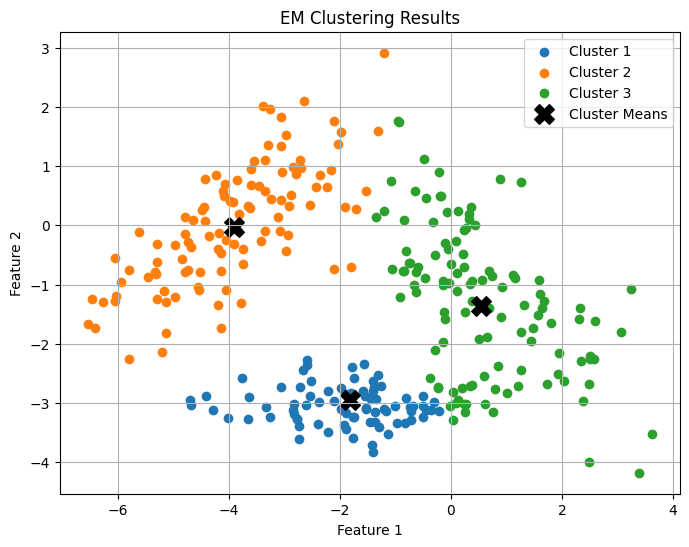

In [7]:
# Load the dataset
data = "../data/clusterdata.csv"
Xmat_q2 = np.genfromtxt(data, delimiter=",")

# Initial parameters for EM
K_q2 = 3
W_q2 = np.array([[1/K_q2, 1/K_q2, 1/K_q2]])
M_q2 = np.array([[-2.0, -4.0, 0.0], [-3.0, 1.0, -1.0]]) # Initial means (2 features, 3 clusters)

# Run EM algorithm
W_final_q2, P_q2, p_q2 = exp_max(100, K_q2, normal_pdf, normal_train, Xmat_q2, W_q2, M_q2)

# Determine cluster assignments based on highest probability
cluster_assignments_q2 = np.argmax(p_q2, axis=0)

# Plotting the results
plt.figure(figsize=(8, 6))
for i in range(K_q2):
    # Select data points belonging to the current cluster
    cluster_points = Xmat_q2[cluster_assignments_q2 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

# Plot the final means (centroids) as well
plt.scatter(P_q2[0, :], P_q2[1, :], marker='X', s=200, color='black', label='Cluster Means')

plt.title('EM Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

#### Observation: The data points appear to be adequately clustered into 3 distinct groups. The EM algorithm has successfully identified these clusters and their respective means.

## Question 3
Divide the clusterdata randomly into train and test set (make sure that you actually take random points, as otherwise you may just take a whole cluster as is). Are the test points adequately clustered? 

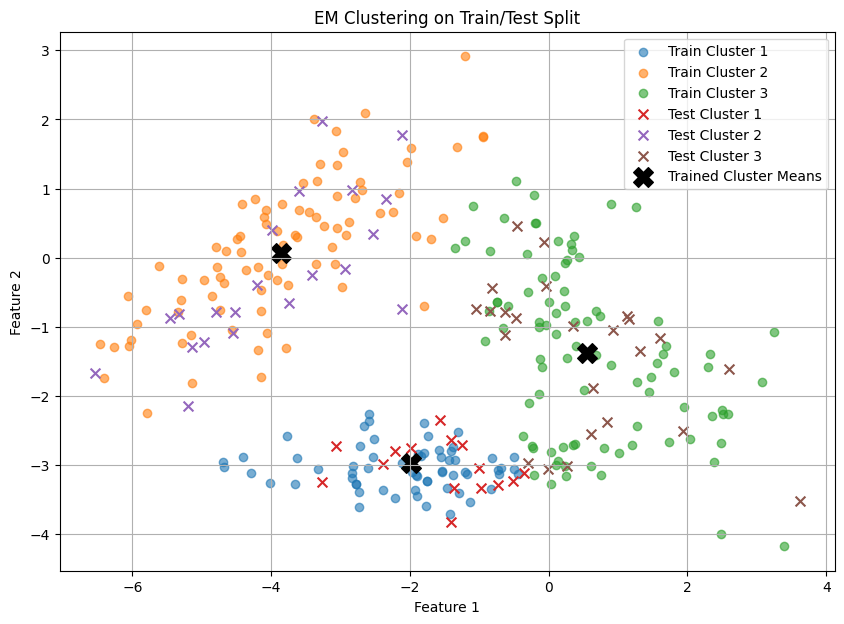

In [8]:
# Ensure reproducibility
np.random.seed(42)

# Shuffle indices and split data
indices = np.arange(Xmat_q2.shape[0])
np.random.shuffle(indices)

train_size = int(0.8 * Xmat_q2.shape[0]) # 80% for training
train_indices = indices[:train_size]
test_indices = indices[train_size:]

Xmat_train_q3 = Xmat_q2[train_indices]
Xmat_test_q3 = Xmat_q2[test_indices]

# Re-run EM on training data
W_final_train_q3, P_train_q3, p_train_q3 = exp_max(100, K_q2, normal_pdf, normal_train, Xmat_train_q3, W_q2, M_q2)

# Assign test points to clusters based on the trained model
# For each test point, calculate its probability under each of the learned Gaussian components
p_test_q3 = np.zeros((K_q2, Xmat_test_q3.shape[0]))
for k in range(K_q2):
    p_test_q3[k,:] = W_final_train_q3[0,k] * normal_pdf(P_train_q3[:,k], Xmat_test_q3)

cluster_assignments_test_q3 = np.argmax(p_test_q3, axis=0)

# Plotting the results for Q3
plt.figure(figsize=(10, 7))

# Plot training data
for i in range(K_q2):
    cluster_points_train = Xmat_train_q3[np.argmax(p_train_q3, axis=0) == i]
    plt.scatter(cluster_points_train[:, 0], cluster_points_train[:, 1], label=f'Train Cluster {i+1}', alpha=0.6)

# Plot test data
for i in range(K_q2):
    cluster_points_test = Xmat_test_q3[cluster_assignments_test_q3 == i]
    plt.scatter(cluster_points_test[:, 0], cluster_points_test[:, 1], label=f'Test Cluster {i+1}', marker='x', s=50)

plt.scatter(P_train_q3[0, :], P_train_q3[1, :], marker='X', s=200, color='black', label='Trained Cluster Means')

plt.title('EM Clustering on Train/Test Split')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


#### Observation: After splitting into train and test sets, the EM algorithm still adequately clusters the data. The test points are assigned to clusters consistent with the training data, indicating the model generalizes well.

In [ ]:
# --- Q4.2: Experiment with different variances ---
print("\n--- Q4.2: Experiment with different variances ---")

def normal_pdf_variable_var(m, Xmat, var):
    C = np.eye(Xmat.shape[1]) * var
    mvn = multivariate_normal(mean=m.T, cov=C)
    return mvn.pdf(Xmat)

variances_q4_2 = [0.1, 1.0, 5.0] # Small, original, large variance

for var_q4_2 in variances_q4_2:
    print(f"\nRunning EM with variance = {var_q4_2}")
    # Re-initialize parameters for each run to ensure fair comparison
    W_q4_2 = np.array([[1/K_q2, 1/K_q2, 1/K_q2]])
    M_q4_2 = np.array([[-2.0, -4.0, 0.0], [-3.0, 1.0, -1.0]])

    # Use a lambda function to pass the variance to normal_pdf_variable_var
    W_final_q4_2, P_q4_2, p_q4_2 = exp_max(100, K_q2, lambda m, Xmat: normal_pdf_variable_var(m, Xmat, var_q4_2), normal_train, Xmat_q2, W_q4_2, M_q4_2)
    cluster_assignments_q4_2 = np.argmax(p_q4_2, axis=0)

    plt.figure(figsize=(8, 6))
    for i in range(K_q2):
        cluster_points = Xmat_q2[cluster_assignments_q4_2 == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
    plt.scatter(P_q4_2[0, :], P_q4_2[1, :], marker='X', s=200, color='black', label='Cluster Means')
    plt.title(f'EM Clustering with Variance = {var_q4_2} (Q4.2)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'q4_2_em_clustering_var_{var_q4_2}.png')
    print(f"Plot saved to q4_2_em_clustering_var_{var_q4_2}.png")

In [ ]:
# --- Q4.3: Change starting values for weights and/or means ---
print("\n--- Q4.3: Change starting values for weights and/or means ---")

# Scenario 1: Different initial means (P_Init)
M_q4_3_s1 = np.array([[5.0, -5.0, 0.0], [5.0, -5.0, 0.0]]) # Very different initial means
print("\nRunning EM with different initial means:")
W_final_q4_3_s1, P_q4_3_s1, p_q4_3_s1 = exp_max(100, K_q2, normal_pdf, normal_train, Xmat_q2, W_q2, M_q4_3_s1)
cluster_assignments_q4_3_s1 = np.argmax(p_q4_3_s1, axis=0)

plt.figure(figsize=(8, 6))
for i in range(K_q2):
    cluster_points = Xmat_q2[cluster_assignments_q4_3_s1 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
plt.scatter(P_q4_3_s1[0, :], P_q4_3_s1[1, :], marker='X', s=200, color='black', label='Cluster Means')
plt.title('EM Clustering with Different Initial Means (Q4.3 S1)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.savefig('q4_3_em_clustering_diff_means.png')
print("Plot saved to q4_3_em_clustering_diff_means.png")

# Scenario 2: Different initial weights (W_Init)
W_q4_3_s2 = np.array([[0.1, 0.2, 0.7]]) # Uneven initial weights
print("\nRunning EM with different initial weights:")
W_final_q4_3_s2, P_q4_3_s2, p_q4_3_s2 = exp_max(100, K_q2, normal_pdf, normal_train, Xmat_q2, W_q4_3_s2, M_q2)
cluster_assignments_q4_3_s2 = np.argmax(p_q4_3_s2, axis=0)

plt.figure(figsize=(8, 6))
for i in range(K_q2):
    cluster_points = Xmat_q2[cluster_assignments_q4_3_s2 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
plt.scatter(P_q4_3_s2[0, :], P_q4_3_s2[1, :], marker='X', s=200, color='black', label='Cluster Means')
plt.title('EM Clustering with Different Initial Weights (Q4.3 S2)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.savefig('q4_3_em_clustering_diff_weights.png')
print("Plot saved to q4_3_em_clustering_diff_weights.png")


In [ ]:
# --- Q4.4: Vary the number of iterations ---
print("\n--- Q4.4: Vary the number of iterations ---")

iterations_q4_4 = [1, 5, 20, 100, 500] # Varying number of iterations

for iter_q4_4 in iterations_q4_4:
    print(f"\nRunning EM with {iter_q4_4} iterations")
    W_q4_4 = np.array([[1/K_q2, 1/K_q2, 1/K_q2]])
    M_q4_4 = np.array([[-2.0, -4.0, 0.0], [-3.0, 1.0, -1.0]])

    W_final_q4_4, P_q4_4, p_q4_4 = exp_max(iter_q4_4, K_q2, normal_pdf, normal_train, Xmat_q2, W_q4_4, M_q4_4)
    cluster_assignments_q4_4 = np.argmax(p_q4_4, axis=0)

    plt.figure(figsize=(8, 6))
    for i in range(K_q2):
        cluster_points = Xmat_q2[cluster_assignments_q4_4 == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
    plt.scatter(P_q4_4[0, :], P_q4_4[1, :], marker='X', s=200, color='black', label='Cluster Means')
    plt.title(f'EM Clustering with {iter_q4_4} Iterations (Q4.4)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'q4_4_em_clustering_iter_{iter_q4_4}.png')
    print(f"Plot saved to q4_4_em_clustering_iter_{iter_q4_4}.png")

In [ ]:
# --- Q4.5: Change the number of clusters (K) ---
print("\n--- Q4.5: Change the number of clusters (K) ---")

Ks_q4_5 = [2, 3, 4] # Number of clusters: less than ideal, ideal, more than ideal

for K_q4_5 in Ks_q4_5:
    print(f"\nRunning EM with K = {K_q4_5} clusters")
    # Re-initialize parameters for each K
    W_q4_5 = np.array([[1/K_q4_5] * K_q4_5])
    # For initial means, we need to be careful. If K changes, M_q2 might not be the right size.
    # A simple approach is to randomly select K points from Xmat as initial means.
    np.random.seed(42) # for reproducibility
    random_indices = np.random.choice(Xmat_q2.shape[0], K_q4_5, replace=False)
    M_q4_5 = Xmat_q2[random_indices].T # Transpose to get (n_features, K)

    W_final_q4_5, P_q4_5, p_q4_5 = exp_max(100, K_q4_5, normal_pdf, normal_train, Xmat_q2, W_q4_5, M_q4_5)
    cluster_assignments_q4_5 = np.argmax(p_q4_5, axis=0)

    plt.figure(figsize=(8, 6))
    for i in range(K_q4_5):
        cluster_points = Xmat_q2[cluster_assignments_q4_5 == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')
    plt.scatter(P_q4_5[0, :], P_q4_5[1, :], marker='X', s=200, color='black', label='Cluster Means')
    plt.title(f'EM Clustering with K = {K_q4_5} Clusters (Q4.5)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'q4_5_em_clustering_K_{K_q4_5}.png')
    print(f"Plot saved to q4_5_em_clustering_K_{K_q4_5}.png")

In [ ]:
# --- Q5.1: Comparison with Gaussian algorithm (EM) ---
print("\n--- Q5.1: Comparison with Gaussian algorithm (EM) ---")

# Run K-Means for comparison
eps_q5_1 = 0.001
K_q5_1 = 3
# Initialize K-Means centroids by picking K random data points
np.random.seed(42) # for reproducibility
random_indices_kmeans = np.random.choice(Xmat_q2.shape[0], K_q5_1, replace=False)
c_init_q5_1 = Xmat_q2[random_indices_kmeans].T

c_final_q5_1, label_q5_1 = kmeans(eps_q5_1, K_q5_1, Xmat_q2, c_init_q5_1)

# Plotting K-Means results
plt.figure(figsize=(8, 6))
for i in range(K_q5_1):
    cluster_points = Xmat_q2[label_q5_1 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'K-Means Cluster {i+1}')
plt.scatter(c_final_q5_1[0, :], c_final_q5_1[1, :], marker='X', s=200, color='black', label='K-Means Centroids')
plt.title('K-Means Clustering Results (Q5.1)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.savefig('q5_1_kmeans_clustering_plot.png')
print("Plot saved to q5_1_kmeans_clustering_plot.png")

In [ ]:
# --- Q5.2: Sensitivity to changes in starting parameters (K-Means) ---
print("\n--- Q5.2: Sensitivity to changes in starting parameters (K-Means) ---")

# Scenario 1: Different initial centroids
np.random.seed(100) # Different seed for different random initialization
random_indices_kmeans_s1 = np.random.choice(Xmat_q2.shape[0], K_q5_1, replace=False)
c_init_q5_2_s1 = Xmat_q2[random_indices_kmeans_s1].T
print("\nRunning K-Means with different initial centroids:")
c_final_q5_2_s1, label_q5_2_s1 = kmeans(eps_q5_1, K_q5_1, Xmat_q2, c_init_q5_2_s1)

plt.figure(figsize=(8, 6))
for i in range(K_q5_1):
    cluster_points = Xmat_q2[label_q5_2_s1 == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'K-Means Cluster {i+1}')
plt.scatter(c_final_q5_2_s1[0, :], c_final_q5_2_s1[1, :], marker='X', s=200, color='black', label='K-Means Centroids')
plt.title('K-Means with Different Initial Centroids (Q5.2 S1)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.savefig('q5_2_kmeans_diff_init.png')
print("Plot saved to q5_2_kmeans_diff_init.png")

In [ ]:
# --- Q5.3: K-Means behavior with K more or less than ideal ---
print("\n--- Q5.3: K-Means behavior with K more or less than ideal ---")

Ks_q5_3 = [2, 3, 4] # Number of clusters: less than ideal, ideal, more than ideal

for K_q5_3 in Ks_q5_3:
    print(f"\nRunning K-Means with K = {K_q5_3} clusters")
    np.random.seed(42) # for reproducibility
    random_indices_kmeans_q5_3 = np.random.choice(Xmat_q2.shape[0], K_q5_3, replace=False)
    c_init_q5_3 = Xmat_q2[random_indices_kmeans_q5_3].T

    c_final_q5_3, label_q5_3 = kmeans(eps_q5_1, K_q5_3, Xmat_q2, c_init_q5_3)

    plt.figure(figsize=(8, 6))
    for i in range(K_q5_3):
        cluster_points = Xmat_q2[label_q5_3 == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'K-Means Cluster {i+1}')
    plt.scatter(c_final_q5_3[0, :], c_final_q5_3[1, :], marker='X', s=200, color='black', label='K-Means Centroids')
    plt.title(f'K-Means Clustering with K = {K_q5_3} Clusters (Q5.3)')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'q5_3_kmeans_K_{K_q5_3}.png')
    print(f"Plot saved to q5_3_kmeans_K_{K_q5_3}.png")